In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

In [142]:
df = pd.read_csv('data_all.csv', sep=';', usecols=['name', 'surname', 'sport', 'start', 'end', 'top', 'reps', 'impr'])
df['impr'] = df['impr'].map(lambda x: float(int(x[:-1])) / 100)
df['reps'] = df['reps'].map(lambda x: int(x[:-1]))
df['sport'] = df['sport'].replace({'rozhodčí basket': 'basketbal', 'hokej golman': 'hokej', 'fotbal golman': 'fotbal'})
df = df[(df['impr'] < 10) & (df['reps'] < 300) & (df['impr'] > 1.1)]
df.head()

,name,surname,sport,start,end,top,reps,impr
0,Lucie,Halakucová,softball,0.90,1.54,1.95,30,3.20
1,Eliska,Thompsonova,softball,0.68,1.99,2.60,91,4.54
2,Matyáš,Vágner,fotbal,0.98,2.14,2.43,45,3.16
3,Charlotte,Velichova,basketbal,1.14,1.61,1.96,18,3.37
4,Simon,Hrubec,hokej,0.52,2.16,2.58,88,5.72


In [143]:
df['sport'].value_counts()

hokej                19
basketbal            12
softball             10
fotbal                8
tenis                 2
florbal               1
stolní tenis          1
violoncello           1
aikido                1
pozemní hokej         1
sjezdové lyžování     1
CMP                   1
baseball              1
MMA                   1
Name: sport, dtype: int64

### Distribuce zlepšení, opakování a celkový graf

Z datasetu jsem odebral "odlehlé hodnoty" - vzorky s moc odlišnými hodnotami. Ony
pak totiž kurví statistiku. V našem případě to bylo zlepšení přes 1000 %, počet opakování
přes 300 nebo zlepšení pod 110 %

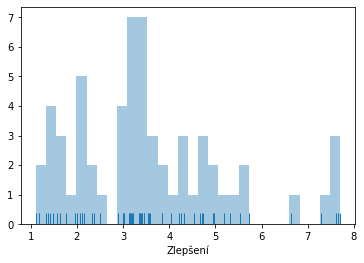

In [144]:
ax = sns.distplot(df['impr'], bins=30, kde=False, rug=True, label='Distribuce zlepšení',
             axlabel='Zlepšení')
ax.get_figure().savefig('zlepseni.png')


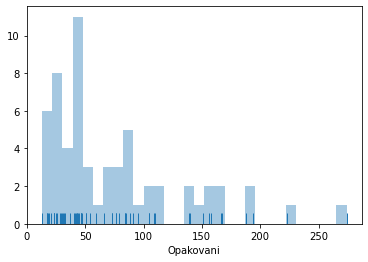

In [145]:
ax = sns.distplot(df['reps'], bins=30, kde=False, rug=True, label='Distribuce opakovani',
             axlabel='Opakovani')
ax.get_figure().savefig('opak.png')


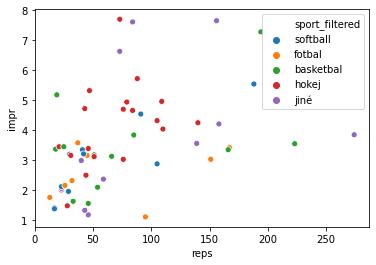

In [146]:
wcs = df['sport'].value_counts()
sports_filtered = df['sport'].map(lambda x:
                                  x if wcs.loc[x] >= 4
                                  else 'jiné')
df['sport_filtered'] = sports_filtered

ax = sns.scatterplot(x=df['reps'], y=df['impr'], hue=df['sport_filtered'])
ax.get_figure().savefig('zlepseni_x_reps.png')
ax

### Zlepšili se ti, kdo to dělali víckrát?

Podle grafu se dá říct, že s počtem opakování zlepšení tak nějak roste, ale
není to úplně jasně vidět. Pearsonův korelační koeficient vychází 0,42
s p-hodnotou 0.00068, což znamená, že to, že by data byla ve skutečnosti nekorelovaná
je extrémně nepravděpodobné.

Vzhledem k tomu, že ani jedna distribuce (opakování ani zlepšení) není
normální (= gausovka), je lepší použít Spearmanův korelační koeficient,
který detekuje jakoukoliv monotónní závislost. Pearson je pouze pro lineární,
tudíž kdyby ta data tvořila třeba parabolu, vyjde Pearson nízký, byť
ta data jednoznačně závislá budou.

Spearman vychází 0,52 s ještě nižší p-hodnotou, můžeme si tedy být docela
jistí, že v datech je nějaká rostoucí závislost, byť ne moc silná

In [147]:
scipy.stats.pearsonr(x=df['reps'], y=df['impr'])

(0.4264386847325134, 0.0006800805759246995)

In [148]:
scipy.stats.spearmanr(a=df['reps'], b=df['impr'])

SpearmanrResult(correlation=0.5210461282925579, pvalue=1.969935578702016e-05)

Zajímavé je porovnání jednotlivých sportů - u hokejek je středně silná korelace
průkazná na hladině spolehlivosti 95 %, u softballistů je to totál sicher
a u basketbalistů je to naprosto neprůkazný - moc vysoké p-hodnoty, hladina
spolehlivosti by byla nějakých 52 % u Spearmana, což je naprosto nepoužitelné.

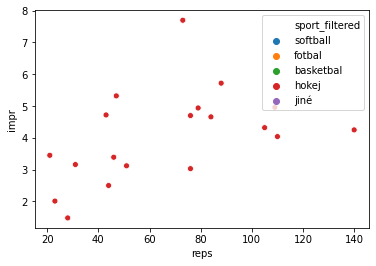

(0.4680650829835125, 0.04327373790913669)
SpearmanrResult(correlation=0.4835454612054436, pvalue=0.035950357907161015)


In [149]:
s = 'hokej'
df_sport = df[df['sport'] == s]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr'], hue=df['sport_filtered'])
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))

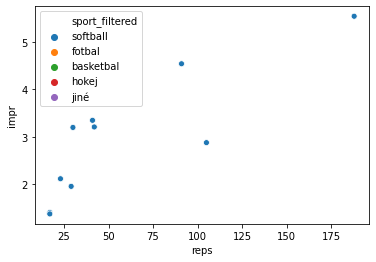

(0.8413838495025128, 0.0022762281116641614)
SpearmanrResult(correlation=0.8510677611520904, pvalue=0.0017911300301950454)


In [150]:
s = 'softball'
df_sport = df[df['sport'] == s]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr'], hue=df['sport_filtered'])
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))

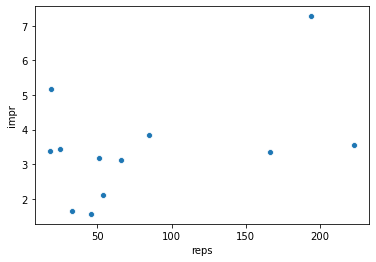

(0.43994374876881254, 0.1523750488651165)
SpearmanrResult(correlation=0.22377622377622378, pvalue=0.48445166145539886)


In [151]:
s = 'basketbal'
df_sport = df[(df['sport'] == s) | (df['sport'] == 'rozhodčí basket')]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr'])
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))
